In [28]:
import uproot
import coffea
from coffea import hist
import numpy as np
import seutils
from math import pi

%matplotlib inline
import matplotlib.pyplot as plt

In [188]:
base = 'root://cmseos.fnal.gov//store/user/klijnsma/semivis/flatntuple_Apr30/'
datasets = [base +d for d in [
    'merged_Mar25s-channel_mMed-150_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-250_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-450_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-450_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-50_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-50_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-650_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-650_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    ]]
rootfile = datasets[1]
print(rootfile)
mz = int(rootfile.split('mMed-')[-1].split('_')[0])
print('mz =', mz)
rinv = float(rootfile.split('rinv-')[-1].split('_')[0])
print('rinv =', rinv)

root://cmseos.fnal.gov//store/user/klijnsma/semivis/flatntuple_Apr30/merged_Mar25s-channel_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root
mz = 250
rinv = 0.3


In [3]:
fin = uproot.open(rootfile)
tree = fin[b'SoftdropAnalyzer'][b'tree']
def get_branch(branchname):
    return tree.arrays(branchname)[branchname]

## Some event level stats

In [46]:
all_jets = get_branch(b'all_ak15jet')
is_matched = get_branch(b'is_matched')
jets = get_branch(b'matched_ak15jet')
print('# of jets / evt =', all_jets.counts.sum() / tree.numentries)
print('# of z\'-matched jets / evt =', jets.counts.sum() / tree.numentries)

print('all_jets.shape:', all_jets.shape)
print('is_matched.shape:', is_matched.shape)
print('is_matched[is_matched].counts.sum():', is_matched[is_matched].counts.sum())
print('jets.shape:', jets.shape)
print('jets.counts.sum():', jets.counts.sum())

zprime = get_branch(b'zprime_p4')
print('# of zprimes:', zprime.counts.sum())

# of jets / evt = 11.235633254668157
# of z'-matched jets / evt = 0.7468326915911067
all_jets.shape: (96612,)
is_matched.shape: (96612,)
is_matched[is_matched].counts.sum(): 72153
jets.shape: (96612,)
jets.counts.sum(): 72153
# of zprimes: 72153


## Basic selection function, using HT > 400 and jet-pt > 100

In [144]:
def deltar(l1, l2):
    return deltar_etaphi(l1.eta.flatten(), l1.phi.flatten(), l2.eta.flatten(), l2.phi.flatten())
    
def deltar_etaphi(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = phi1 - phi2
    dphi[dphi > 2.*pi] -= 2.*pi
    dphi[dphi < -2.*pi] += 2.*pi
    dphi[dphi > pi] -= 2.*pi
    dphi[dphi < -pi] += 2.*pi
    return deta, dphi, np.sqrt(deta**2 + dphi**2)

In [99]:
dark_quarks = get_branch(b'final_dark_quarks_p4')
print(dark_quarks.shape)

(96612,)


In [121]:
dr_dark_quarks = np.ones(dark_quarks.shape[0]) * 9999.
events_with_2_dark_quarks = (dark_quarks.counts == 2)
dark_quarks_eta = dark_quarks[events_with_2_dark_quarks].eta.regular()
dark_quarks_phi = dark_quarks[events_with_2_dark_quarks].phi.regular()
deta_dark_quarks, dphi_dark_quarks, dr_dark_quarks_flat = deltar_etaphi(
    dark_quarks_eta[:,0], dark_quarks_phi[:,0],
    dark_quarks_eta[:,1], dark_quarks_phi[:,1]
    )
# Fill in flat array into jagged array
dr_dark_quarks[events_with_2_dark_quarks] = dr_dark_quarks_flat
print(dr_dark_quarks.shape)
print('average dr =', np.mean(dr_dark_quarks_flat), '+/-', np.std(dr_dark_quarks_flat))

(96612,)
average dr = 2.1200858824621722 +/- 0.7347955102499343


/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


Text(0.5, 1.0, '$\\Delta \\phi_{dark quarks}$')

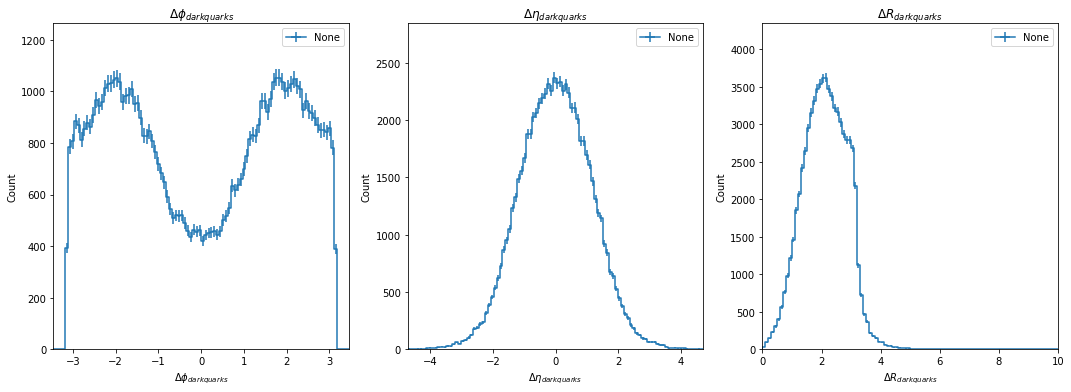

In [132]:
fig, axs = plt.subplots(ncols=3, figsize=(18,6))

drdq = hist.Hist("Count", hist.Bin("drdq", r"$\Delta R_{dark quarks}$", 100, 0., 10.))
drdq.fill(drdq=dr_dark_quarks_flat)
ax = hist.plot1d(drdq, ax=axs[2])
ax.set_title(r"$\Delta R_{dark quarks}$")

hist_deta = hist.Hist("Count", hist.Bin("deta", r"$\Delta \eta_{dark quarks}$", 100, -1.5*pi, 1.5*pi))
hist_deta.fill(deta=deta_dark_quarks)
ax = hist.plot1d(hist_deta, ax=axs[1])
ax.set_title(r"$\Delta \eta_{dark quarks}$")

hist_dphi = hist.Hist("Count", hist.Bin("dphi", r"$\Delta \phi_{dark quarks}$", 100, -1.1*pi, 1.1*pi))
hist_dphi.fill(dphi=dphi_dark_quarks)
ax = hist.plot1d(hist_dphi, ax=axs[0])
ax.set_title(r"$\Delta \phi_{dark quarks}$")

2716

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


[66036 51637 45418 40530 35772 31076 26887 22979 19506 16540 13908 11559
  9506  7773  6263  5048  4059  3286  2665  2162  1771  1493  1243  1012
   856   727   627   523   443   378   337   275   234   203   183   157
   139   110    94    82    73    62    57    54    47    41    38    35
    33    29]
Efficiency for MET > 120.0: 14600


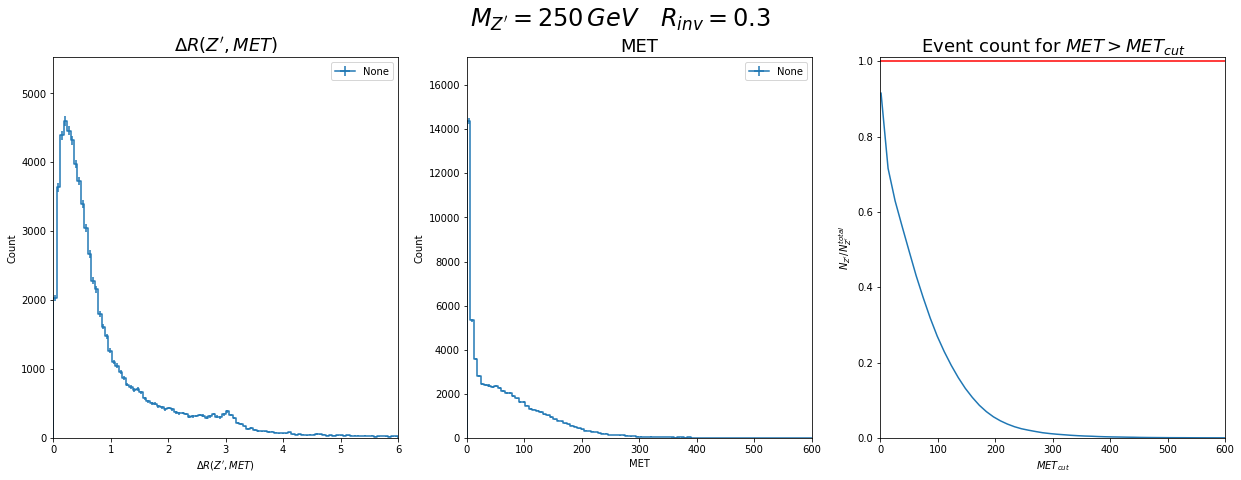

In [191]:
fig, axs = plt.subplots(ncols=3, figsize=(21,7))

met = get_branch(b'met')[zprime.counts > 0]
deta_met, dphi_met, dr_met = deltar(met, zprime)
title = r"$\Delta R(Z^{\prime}, MET)$"
h_drmet = hist.Hist("Count", hist.Bin("dr_met", title, 100, 0., 6.))
h_drmet.fill(dr_met=dr_met)
hist.plot1d(h_drmet, ax=axs[0])
axs[0].set_title(title, fontsize=18)

# title = r'$p_{T}^{MET}$'
title = 'MET'
h_ptmet = hist.Hist("Count", hist.Bin("pt_met", title, 100, 0., 600.))
h_ptmet.fill(pt_met=met.pt)
hist.plot1d(h_ptmet, ax=axs[1])
axs[1].set_title(title, fontsize=18)

min_mets = np.linspace(1., 600, 50)
count_min_mets = np.array(
    [ zprime[zprime.counts > 0][met.pt > min_met].counts.sum() for min_met in min_mets ]
    )
print(count_min_mets)
count_min_mets = count_min_mets / float(zprime.counts.sum())
axs[2].plot([0., 600.], [1., 1.], c='r')
axs[2].plot(min_mets, count_min_mets)
axs[2].set_title(r'Event count for $MET > MET_{cut}$', fontsize=18)
axs[2].set_xlabel(r'$MET_{cut}$')
axs[2].set_ylabel(r'$N_{Z^{\prime}} / N^{total}_{Z^{\prime}}$')
axs[2].set_xlim(0., 600.)
axs[2].set_ylim(0., 1.01)

fig.suptitle(
    r'$M_{{Z^{{\prime}}}} = {0}\,GeV'
    r' \quad R_{{inv}} = {1:.1f}$'
    .format(mz, rinv),
    fontsize = 24
    )

In [198]:
total = zprime.counts.sum()
def count_min_met(min_met):
    return zprime[zprime.counts > 0][met.pt > min_met].counts.sum() / float(total)

for min_met in [ 30., 50.,  80., 100., 120., 160., 200., 250., 300. ]:
    print('Efficiency for MET > {0:3.0f} GeV: {1:.3f}'.format(min_met, count_min_met(min_met)))


Efficiency for MET >  30 GeV: 0.604
Efficiency for MET >  50 GeV: 0.495
Efficiency for MET >  80 GeV: 0.346
Efficiency for MET > 100 GeV: 0.266
Efficiency for MET > 120 GeV: 0.202
Efficiency for MET > 160 GeV: 0.108
Efficiency for MET > 200 GeV: 0.053
Efficiency for MET > 250 GeV: 0.023
Efficiency for MET > 300 GeV: 0.011


In [186]:
maxdr = 2.0
minpt = 100.
selection = (get_branch(b'all_ak15jet').pt > minpt) & (dr_dark_quarks < maxdr)
matched_selection = selection & is_matched
nonmatched_selection = selection & (~is_matched)

print('After selection:')
print('ak15 jets from a Z\':   ', matched_selection[matched_selection].counts.sum())
print('ak15 jets NOT from a Z\':', nonmatched_selection[nonmatched_selection].counts.sum())

After selection:
ak15 jets from a Z':    28175
ak15 jets NOT from a Z': 40786


In [134]:
def get_matched_nonmatched_branches(varname):
    branch = get_branch(b'all_' + varname)
    matched = branch[matched_selection]
    nonmatched = branch[nonmatched_selection]
    if matched.counts.sum() == 0: print('WARNING: Matched selection for "{0}" is zero'.format(varname))
    if nonmatched.counts.sum() == 0: print('WARNING: Non-matched selection for "{0}" is zero'.format(varname))
    return matched, nonmatched

def plot_matched_nonmatched_branches(
        varname,
        matched,
        nonmatched,
        xmin=0.,
        xmax=500.,
        title=None,
        ax=None,
        ):
    if not title: title = varname
    h = hist.Hist(
        'Density',
        hist.Cat('thing', title),
        hist.Bin(varname, title, 100, xmin, xmax)
        )
    try:
        matched = matched.flatten()
        nonmatched = nonmatched.flatten()
    except AttributeError:
        print('Could not call .flatten(); should be 1D array now:')
        print(matched.shape)
        print(nonmatched.shape)
    h.fill(thing='matched AK15 jet', **{varname: matched})
    h.fill(thing='non-matched AK15 jet', **{varname: nonmatched})
    if not ax:
        fig = plt.figure(figsize=(7,7))
        ax = fig.gca()
    hist.plot1d(h, ax=ax, density=True)
    ax.set_xlabel(title, fontsize=18)
    ax.set_ylabel('Density', fontsize=18)
    return ax

# Plots

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


Text(0.5, 1.0, '$p_{T}^{Z}$')

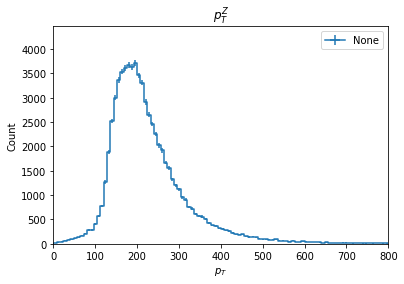

In [135]:
zprime_pt = hist.Hist("Count", hist.Bin("pt", r"$p_{T}$", 100, 0., 800.))
zprime_pt.fill(pt=zprime.pt.flatten())
ax = hist.plot1d(zprime_pt)
ax.set_title(r'$p_{T}^{Z}$')

### Substructure variable plots


/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.001, 3.5009760425909464)

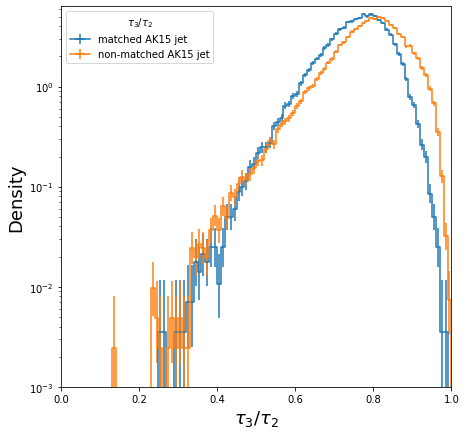

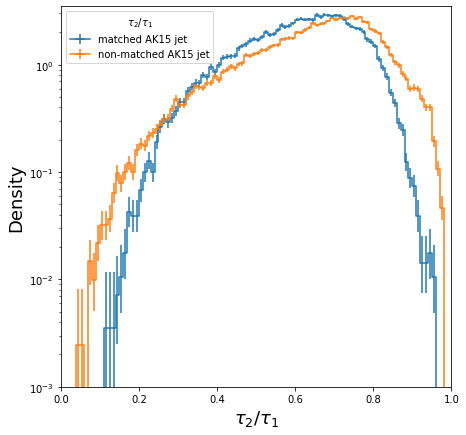

In [136]:
tau3_matched, tau3_nonmatched = get_matched_nonmatched_branches(b'ak15jet_Tau3')
tau2_matched, tau2_nonmatched = get_matched_nonmatched_branches(b'ak15jet_Tau2')
tau1_matched, tau1_nonmatched = get_matched_nonmatched_branches(b'ak15jet_Tau1')

tau32_matched = tau3_matched / tau2_matched
tau32_nonmatched = tau3_nonmatched / tau2_nonmatched
tau21_matched = tau2_matched / tau1_matched
tau21_nonmatched = tau2_nonmatched / tau1_nonmatched

ax32 = plot_matched_nonmatched_branches('tau32', tau32_matched, tau32_nonmatched, xmin=0., xmax=1., title=r'$\tau_{3} / \tau_{2}$')
ax32.set_yscale('log')
ax32.set_ylim(0.001)
ax21 = plot_matched_nonmatched_branches('tau21', tau21_matched, tau21_nonmatched, xmin=0., xmax=1., title=r'$\tau_{2} / \tau_{1}$')
ax21.set_yscale('log')
ax21.set_ylim(0.001)


/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


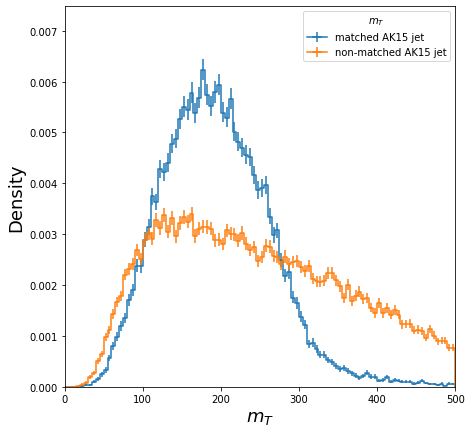

In [137]:
mt_matched, mt_nonmatched = get_matched_nonmatched_branches(b'ak15jet_MTwMET')
ax = plot_matched_nonmatched_branches('mt', mt_matched, mt_nonmatched, title=r'$m_{T}$')

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


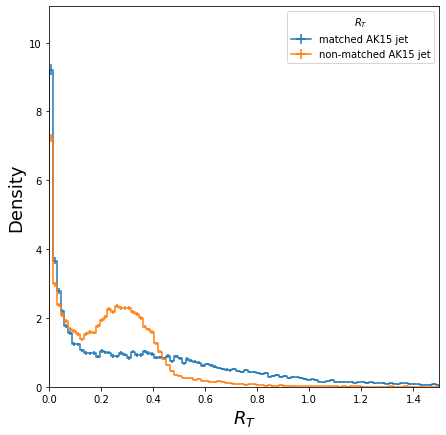

In [139]:
met = get_branch(b'met').pt
rt_matched = met / mt_matched
rt_nonmatched = met / mt_nonmatched
ax = plot_matched_nonmatched_branches('rt', rt_matched, rt_nonmatched, title=r'$R_{T}$', xmax=1.5)

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.0001, 0.009724549721109664)

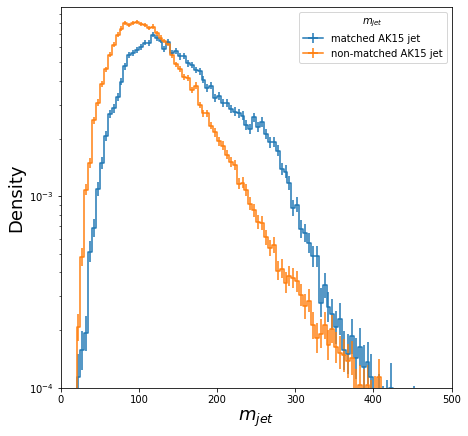

In [140]:
jets_matched, jets_nonmatched = get_matched_nonmatched_branches(b'ak15jet')
jetmass_matched = np.array([float(j.mass) for j in jets_matched.flatten() if j.mag2 >= 0.])
jetmass_nonmatched = np.array([float(j.mass) for j in jets_nonmatched.flatten() if j.mag2 >= 0.])
ax = plot_matched_nonmatched_branches('jetmass', jetmass_matched, jetmass_nonmatched, title=r'$m_{jet}$')
ax.set_yscale('log')
ax.set_ylim(0.0001)

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.0001, 0.04770277907462467)

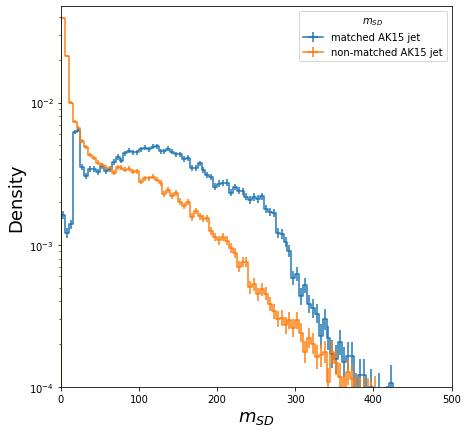

In [141]:
summedsdjet_matched, summedsdjet_nonmatched = get_matched_nonmatched_branches(b'summedsubjets')
msd_matched = np.array([float(j.mass) for j in summedsdjet_matched.flatten() if j.mag2 >= 0.])
msd_nonmatched = np.array([float(j.mass) for j in summedsdjet_nonmatched.flatten() if j.mag2 >= 0.])
ax = plot_matched_nonmatched_branches('msd', msd_matched, msd_nonmatched, title=r'$m_{SD}$')
ax.set_yscale('log')
ax.set_ylim(0.0001)

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


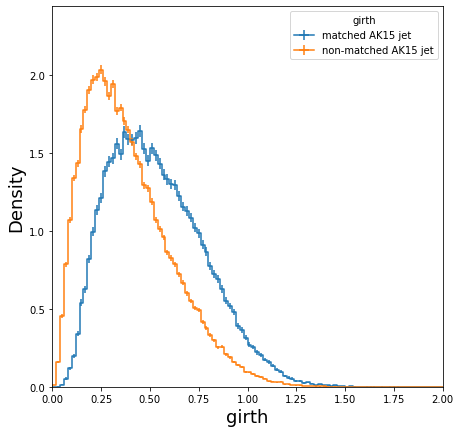

In [189]:
girth_matched, girth_nonmatched = get_matched_nonmatched_branches(b'ak15jet_MomentGirth')
ax = plot_matched_nonmatched_branches('girth', girth_matched, girth_nonmatched, xmax=2.)

# Subjet logic

In [54]:
subjet = get_branch(b'all_subjets')
subjet_index = get_branch(b'all_subjets_index')
subjet_count = get_branch(b'all_subjets_count')

In [79]:
print(subjet.counts)
print(subjet_index.counts)
print(subjet_count.counts)
print(np.unique(subjet_count.flatten()))
print(subjet_count[21])

[26 34 18 24 18 14 18 28 24 16 16 22 18 28 28 16 28 30 20 22  8  9 26 28
 22 12 26 20 24 12 28 22 26 20 26 10 22 14 18 24 30 26 12 22 28 18 28 14
 12 10 24 24 22 16 26 16 16 34 10 18 22 24 24 32 16 16 22 20 14 26 26 20
 28 26 26 26 28 22 14 28 32 30 24 14 18 32 18 30 26 18 14 22 16 26 22 21
 20 32 28 26]
[26 34 18 24 18 14 18 28 24 16 16 22 18 28 28 16 28 30 20 22  8  9 26 28
 22 12 26 20 24 12 28 22 26 20 26 10 22 14 18 24 30 26 12 22 28 18 28 14
 12 10 24 24 22 16 26 16 16 34 10 18 22 24 24 32 16 16 22 20 14 26 26 20
 28 26 26 26 28 22 14 28 32 30 24 14 18 32 18 30 26 18 14 22 16 26 22 21
 20 32 28 26]
[13 17  9 12  9  7  9 14 12  8  8 11  9 14 14  8 14 15 10 11  4  5 13 14
 11  6 13 10 12  6 14 11 13 10 13  5 11  7  9 12 15 13  6 11 14  9 14  7
  6  5 12 12 11  8 13  8  8 17  5  9 11 12 12 16  8  8 11 10  7 13 13 10
 14 13 13 13 14 11  7 14 16 15 12  7  9 16  9 15 13  9  7 11  8 13 11 11
 10 16 14 13]
[1 2]
[2 2 1 2 2]


In [51]:
subjet[subjet_index == 18].counts

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Example plots

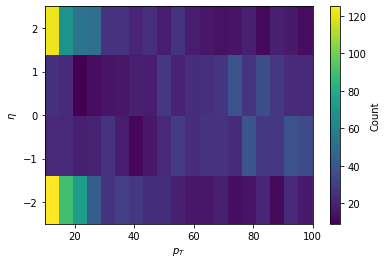

In [156]:
jet_kinematics = hist.Hist(
    "Count",
    hist.Bin("pt", r"$p_{T}$", 19, 10, 100),
    hist.Bin("eta", r"$\eta$", [-2.5, -1.4, 0, 1.4, 2.5]),
    )
jet_kinematics.fill(pt=jets.pt.flatten(), eta=jets.eta.flatten())
ax = hist.plot2d(jet_kinematics, xaxis='pt')

/uscms_data/d3/klijnsma/miniconda3/envs/condaroot/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


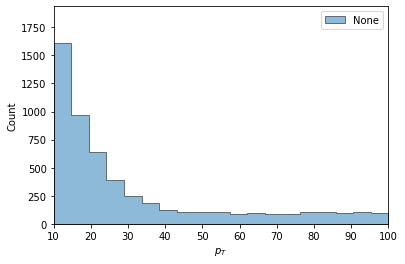

In [157]:
jet_pt = jet_kinematics.integrate("eta", overflow='under')

ax = hist.plot1d(
    jet_pt,
    fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3)}
    )